In [1]:
#Step 1. Load Packages and load Data
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as spio
import datetime as dt
import scipy.stats as stats
import random
import squarify

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 

import warnings
warnings.filterwarnings("ignore")

TickerNWeights = pd.read_excel('Public companies in Mass.xlsx', sheet_name='MassIndex', header=0)
Ticker_AllStock_Mass = TickerNWeights['Ticker']
wts_AllStock_Mass = TickerNWeights['weights']

def getDataBatch(tickers, startdate, enddate):
  def getData(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map(getData, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))
def getReturns(tickers, start_dt, end_dt, freq='monthly'): 
    px_data = getDataBatch(tickers, start_dt, end_dt)
    # Isolate the `Adj Close` values and transform the DataFrame
    px = px_data[['Adj Close']].reset_index().pivot(index='Date', 
                           columns='Ticker', values='Adj Close')
    if (freq=='monthly'):
        px = px.resample('M').last()
        
    # Calculate the daily/monthly percentage change
    ret = px.pct_change().dropna()
    
    ret.columns = tickers
    return(ret)
start_dt = datetime.datetime(2008,10, 31)
end_dt = datetime.datetime(2018, 10,31)


Flag_downloadData = True


if Flag_downloadData:
    stock_data = getDataBatch(Ticker_AllStock_Mass, start_dt, end_dt)
    # Isolate the `Adj Close` values and transform the DataFrame
    Price_AllStock_Mass = stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
    Price_AllStock_Mass = Price_AllStock_Mass[list(Ticker_AllStock_Mass)]
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter('IndexPrice_Mass.xlsx', engine='xlsxwriter')
    Price_AllStock_Mass.to_excel(writer, sheet_name='Price',startrow=0, startcol=0, header=True, index=True)
else:
    Price_AllStock_Mass = pd.read_excel('IndexPrice_Mass.xlsx', sheet_name='Price',
                    header=0, index_col = 0)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

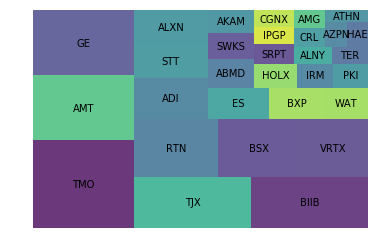

<Figure size 432x288 with 0 Axes>

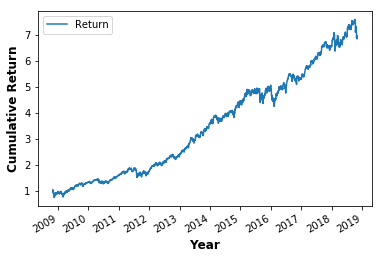

In [2]:
#Step 2.Data Analysis
squarify.plot(sizes=TickerNWeights['weights'], label=TickerNWeights['Ticker'], alpha=.8 )
plt.axis('off')
plt.show()

#Calculate return and plot 
ret_AllStock = Price_AllStock_Mass.pct_change().dropna()
ret_benchmark = np.dot(ret_AllStock,wts_AllStock_Mass)
dates = ret_AllStock.index
benchmark = pd.DataFrame(ret_benchmark,index=dates,columns=['Return'])
cum = (benchmark + 1).cumprod()

plt.figure()
cum.plot()
plt.xlabel('Year',fontSize=12,fontWeight='bold',color='k')
plt.ylabel('Cumulative Return',fontSize=12,fontWeight='bold',color='k')

#Data Partition
percentage_of_train=0.65
number_of_traindata=int(percentage_of_train*len(ret_AllStock))
train, test = ret_AllStock.iloc[0:number_of_traindata], ret_AllStock.iloc[number_of_traindata:2571]



19 top weighted stock replication TE =  4.91 bps


<Figure size 432x288 with 0 Axes>

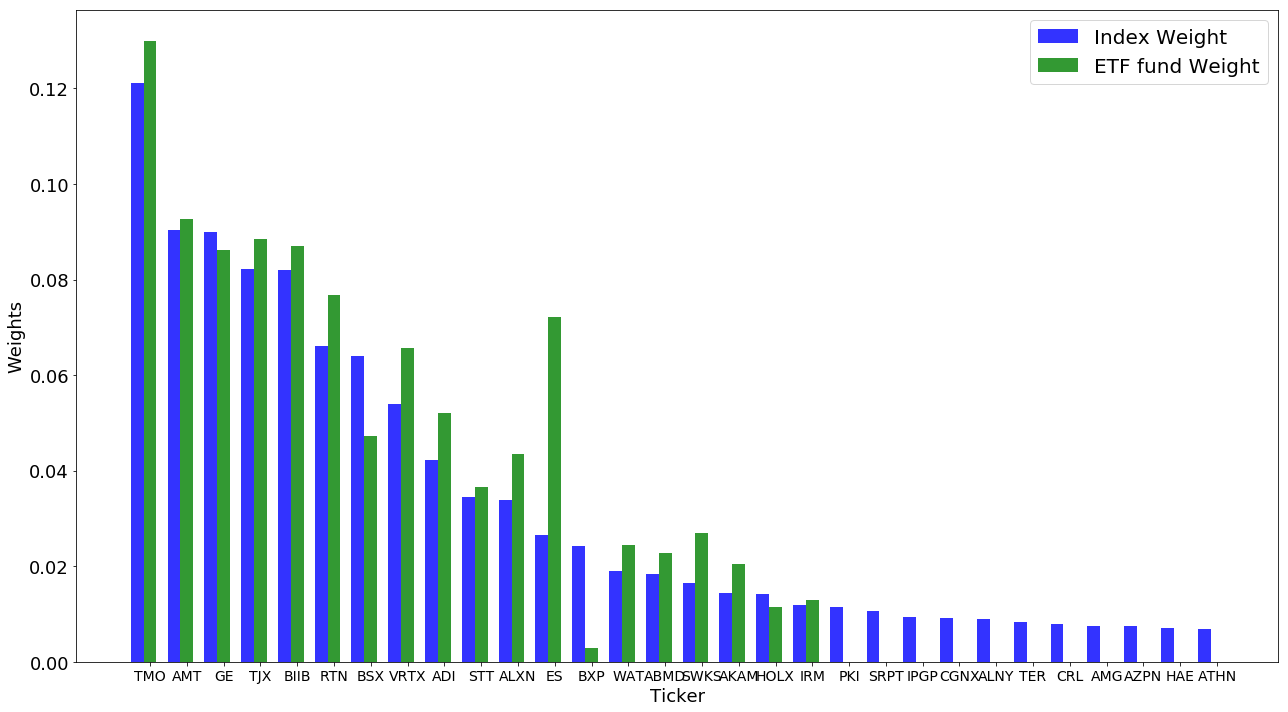

<Figure size 432x288 with 0 Axes>

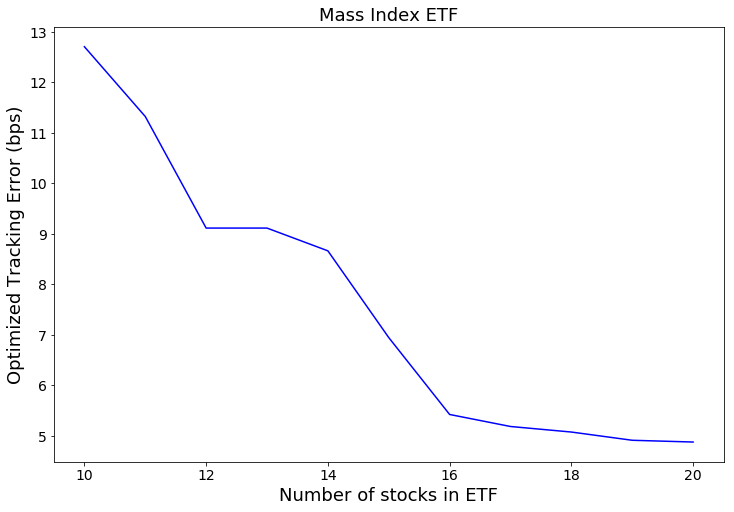

In [3]:
#Step 3. Trarcking Error Optimization in training data
import risk_opt_2Student as riskopt 

def tracking_error(wts_active,cov):
    TE = np.sqrt(np.transpose(wts_active)@cov@wts_active)
    return TE

num_periods, num_stock = train.shape
lamda = 0.94 
vols = train.std()
rets_mean = train.mean()
ret_AllStock = train - rets_mean

var_ewma = riskopt.ewma_cov(ret_AllStock, lamda)
var_ewma_annual = var_ewma*252 
cov_end = var_ewma[-1,:]

cov_end_annual = cov_end*252 
std_end_annual = np.sqrt(np.diag(cov_end))*np.sqrt(252)
corr = ret_AllStock.corr()

num_of_stock=19
included_stk=random.sample(range(1,30),num_of_stock)
l=list(range(1,31))
excluded_stk=[x for x in l if x not in included_stk]


b1a_ = [(-1.0,1.0) for i in included_stk] 
b1b_ = [(0.0,0.0) for i in excluded_stk] 
b1_ = b1a_ + b1b_
c1_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })  
wts_min_trackingerror2 = riskopt.opt_min_te(wts_AllStock_Mass, cov_end_annual, b1_, c1_)

wts_active2 = wts_min_trackingerror2 - wts_AllStock_Mass
TE_optimized2 = tracking_error(wts_active2,cov_end)
print('{0} top weighted stock replication TE = {1:5.2f} bps'.format(num_of_stock, TE_optimized2*10000))

num_stock_b = 10
num_stock_e = 21
numstock_2use = range(num_stock_b,num_stock_e)
wts_active_hist = np.zeros([len(numstock_2use), num_stock])
TE_hist = np.zeros([len(numstock_2use), 1])
count = 0

for i in numstock_2use:
    
    b1_c_a_ = [(0.0,1.0) for j in range(i)] 
   
    b1_c_b_ = [(0.0,0.0) for j in range(i,num_stock)] 
    b1_curr_ = b1_c_a_ + b1_c_b_
    wts_min_curr = riskopt.opt_min_te(wts_AllStock_Mass, cov_end_annual, b1_curr_, c1_)
    wts_active_hist[count,:] = wts_min_curr.transpose()
    TE_optimized_c = tracking_error(wts_min_curr-wts_AllStock_Mass,cov_end)
    TE_hist[count,:] = TE_optimized_c*10000
    count = count+1
    
    del b1_curr_, b1_c_a_, b1_c_b_,TE_optimized_c,wts_min_curr

# Plotting.
figure_count = 1

plt.figure(figure_count)
figure_count = figure_count+1
fig, ax = plt.subplots(figsize=(18,10))
index = np.arange(len(wts_AllStock_Mass))
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, wts_AllStock_Mass, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Index Weight')
 
rects2 = plt.bar(index + bar_width, wts_min_trackingerror2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='ETF fund Weight')
 
plt.xlabel('Ticker', fontsize=18)
plt.ylabel('Weights', fontsize=18)
plt.xticks(index + bar_width, (Ticker_AllStock_Mass), fontsize=12)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=18)
plt.legend(fontsize=20)
 
plt.tight_layout()
plt.show()


#------plot TE as a function of number of stocks -------------
plt.figure(figure_count)
figure_count = figure_count+1
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(range(num_stock_b,num_stock_e), TE_hist, 'b')
plt.xlabel('Number of stocks in ETF', fontsize=18)
plt.ylabel('Optimized Tracking Error (bps)', fontsize=18)
plt.title('Mass Index ETF', fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)


In [6]:
#Step 4. Test optimized result in test data
num_periods1, num_stock1 = test.shape
lamda = 0.94 
vols = test.std()
rets_mean = test.mean()
ret_test = test - rets_mean
var_ewma = riskopt.ewma_cov(ret_test, lamda)
var_ewma_annual = var_ewma*252 
cov_end = var_ewma[-1,:]
wts_active2 = wts_min_trackingerror2 - wts_AllStock_Mass
TE_test = tracking_error(wts_active2,cov_end)
print(TE_test)

print('{0} % training data produced test data TE = {1:5.2f} bps'.format(percentage_of_train *100, TE_test*10000))


0.0012965732049655732
65.0 % training data produced test data TE = 12.97 bps
